# Boolean Satisfiability: Dinner Party problem using Grover's algorithm

In [1]:
# Allowed combinations for the party according to the following guidelines:
# 1.It is Alice and Bob's engagement party so they must be invited
# 2.Charles will come only if Dave comes without Eve (iff Dave comes and Eve doesn't)

# A B C D E
# 1 1 0 0 0
# 1 1 0 0 1
# 1 1 0 1 0
# 1 1 0 1 1
# 1 1 1 1 0

# Karnaugh map:
#     CD
#     00 01 11 10
# E 0  1  1  1  0
#   1  1  1  0  0

# The minimized boolean expression turns out to be:
# A.B.(C'+ E'.D)
# or 
# A^B^(~C U ~E^D)

# This can be converted into CNF form:
# A.B.(C'+D).(C'+E')

# Later on, I realised that another expression is more convenient to implement from scratch using quantum gates:
# A.B.~(C.E).~(C.~D)

# Grover's algorithm must search through all possible values of A,B,C,D and E and output the 5 valid combinations we have tabulated above.

# In this project I have shown both the library implementation of Grover's algorithm and the from-scratch quantum circuit implementation, both of which yield the same correct results :D

### Importing libraries

In [2]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
from qiskit_textbook.widgets import binary_widget
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle
from qiskit.circuit.library import PhaseOracle
from qiskit.circuit import QuantumRegister
from qiskit.circuit import ClassicalRegister
from qiskit.compiler import transpile
import numpy as np

# Using library implementation of Grover's algorithm

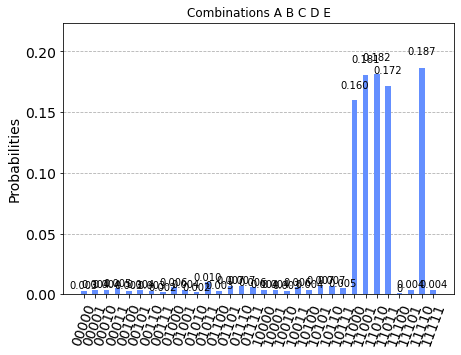

In [3]:
bool_exp = '''
c examples
p cnf 5 4
5 0
4 0
-3 2 0
-3 -1 0
'''
algorithm = Grover(LogicalExpressionOracle(bool_exp))
backend = Aer.get_backend('aer_simulator') 
result = algorithm.run(backend)
plot_histogram(result['measurement'],title='Combinations A B C D E')

# Grover's algorithm implementation from scratch

### Useful functions

In [4]:
#Functions to append hadamard gate and diffuser oracle 
def hadamard(qc, qubits):
    for q in qubits:
        qc.h(q)
    return qc
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

### Creating quantum circuit and initialising states

In [5]:
n= 5
var_qubits = QuantumRegister(5, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(5, name='cbits')
grover_circuit = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)
grover_circuit.initialize([1, -1]/np.sqrt(2), output_qubit)
grover_circuit.initialize([1, 0], clause_qubits[0])
grover_circuit.initialize([1, 0], clause_qubits[1])
grover_circuit.initialize([1, 0], clause_qubits[2])
grover_circuit.initialize([1, 0], clause_qubits[3])


grover_circuit = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)
grover_circuit = hadamard(grover_circuit, var_qubits)
grover_circuit.barrier()


### First iteration

In [6]:
#Implementing boolean exp A.B.~(C.E).~(~D.~E) using Toffoli, CNOT and Bit-flip gates

#individual clauses evaluated using CNOT and X gates
grover_circuit.cx(var_qubits[0],clause_qubits[0])
grover_circuit.cx(var_qubits[1],clause_qubits[1])
grover_circuit.ccx(var_qubits[2],var_qubits[4],clause_qubits[2])
grover_circuit.x(clause_qubits[2])
grover_circuit.x(var_qubits[3])
grover_circuit.ccx(var_qubits[2],var_qubits[3],clause_qubits[3])
grover_circuit.x(clause_qubits[3])

#all clauses are ANDed using Toffoli gate
grover_circuit.mct(clause_qubits, output_qubit)
grover_circuit.barrier()

#Uncomputing to revert clause bits to their original state
grover_circuit.cx(var_qubits[0],clause_qubits[0])
grover_circuit.cx(var_qubits[1],clause_qubits[1])
grover_circuit.x(clause_qubits[2])
grover_circuit.ccx(var_qubits[2],var_qubits[4],clause_qubits[2])
grover_circuit.x(clause_qubits[3])
grover_circuit.ccx(var_qubits[2],var_qubits[3],clause_qubits[3])
grover_circuit.x(var_qubits[3])

In [7]:
grover_circuit.barrier()
grover_circuit.append(diffuser(n), [0,1,2,3,4])

### Second iteration

In [8]:
#Implementing boolean exp A.B.~(C.E).~(~D.~E) using Toffoli, CNOT and Bit-flip gates

#individual clauses evaluated using CNOT and X gates
grover_circuit.cx(var_qubits[0],clause_qubits[0])
grover_circuit.cx(var_qubits[1],clause_qubits[1])
grover_circuit.ccx(var_qubits[2],var_qubits[4],clause_qubits[2])
grover_circuit.x(clause_qubits[2])
grover_circuit.x(var_qubits[3])
grover_circuit.ccx(var_qubits[2],var_qubits[3],clause_qubits[3])
grover_circuit.x(clause_qubits[3])

#all clauses are ANDed using Toffoli gate
grover_circuit.mct(clause_qubits, output_qubit)
grover_circuit.barrier()

#Uncomputing to revert clause bits to their original state
grover_circuit.cx(var_qubits[0],clause_qubits[0])
grover_circuit.cx(var_qubits[1],clause_qubits[1])
grover_circuit.x(clause_qubits[2])
grover_circuit.ccx(var_qubits[2],var_qubits[4],clause_qubits[2])
grover_circuit.x(clause_qubits[3])
grover_circuit.ccx(var_qubits[2],var_qubits[3],clause_qubits[3])
grover_circuit.x(var_qubits[3])

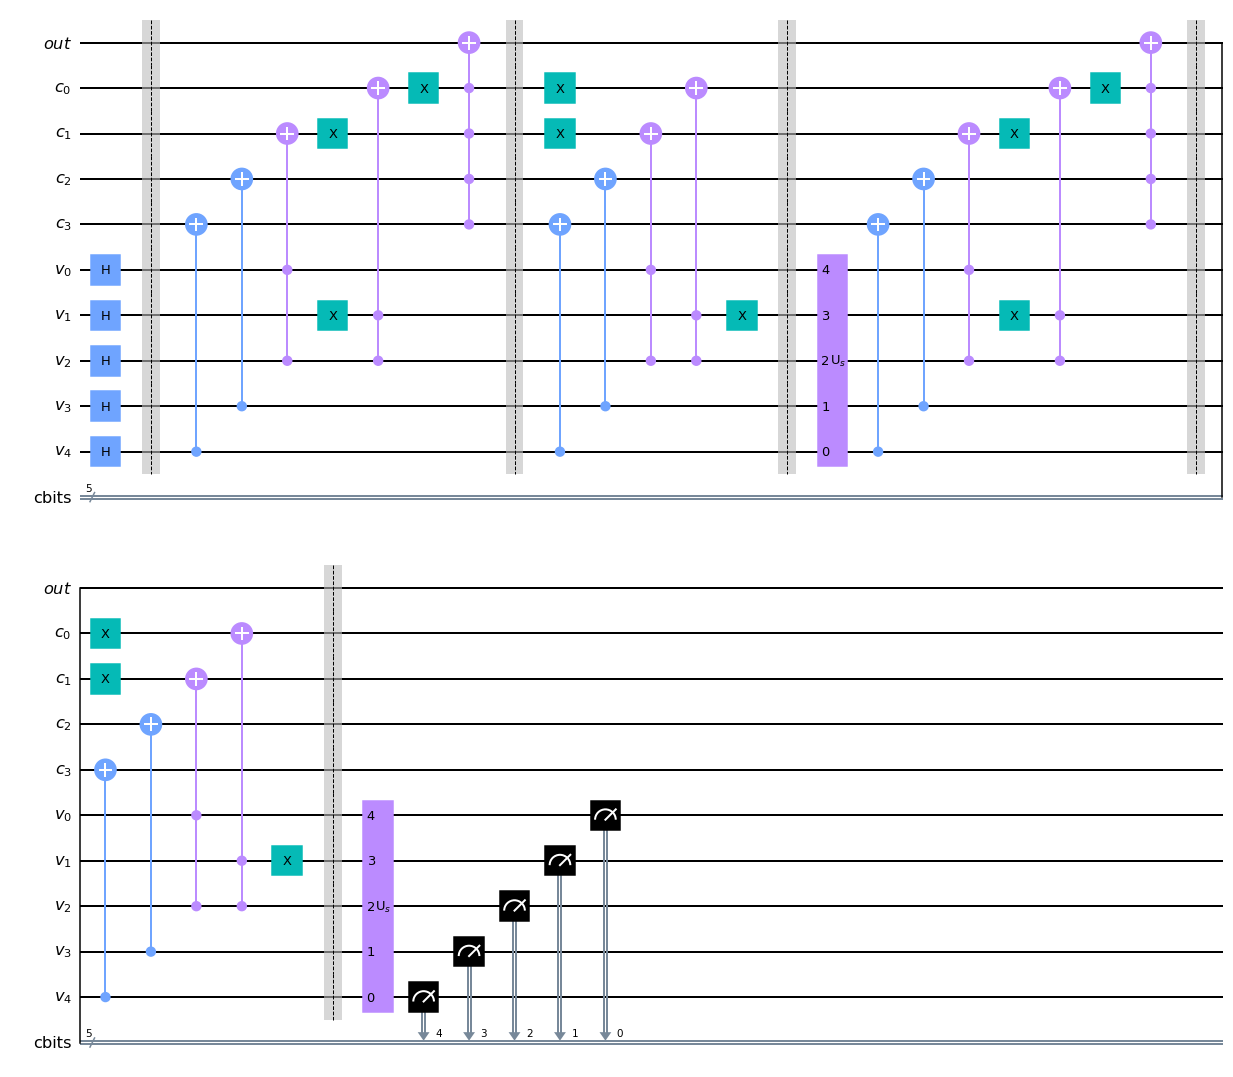

In [9]:
grover_circuit.barrier()
grover_circuit.append(diffuser(n), [0,1,2,3,4])
grover_circuit.measure(var_qubits,cbits)
grover_circuit=grover_circuit.reverse_bits()
grover_circuit.draw('mpl')

## Plotting results

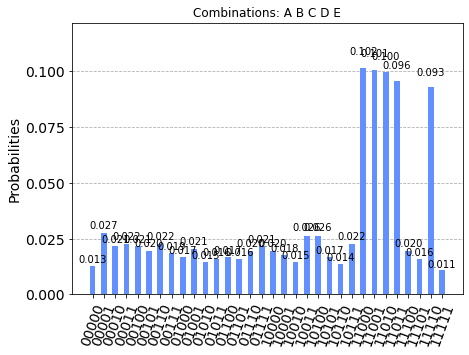

In [10]:
backend = Aer.get_backend('aer_simulator') 
transpiled_qc = transpile(grover_circuit, backend)
qobj = assemble(transpiled_qc)
result = backend.run(qobj).result()
plot_histogram(result.get_counts(),title='Combinations: A B C D E')

As we can observe, the 5 correct combinations
11000,
11001,
11010,
11011,
11110
are given out as output :D